<a href="https://colab.research.google.com/github/arthurcarvalhoc/bach_choral_harmony_eda/blob/main/Pr%C3%A9_Processamento_dos_Dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pré-Processamento dos Dados
Grupo:
- Rafael de Lima Pacheco Silva
- Carlos André Batista
- Arthur Carvalho

In [1]:
!rm jsbach*.*
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00298/jsbach_chorals_harmony.zip
!unzip -o *.zip 

rm: cannot remove 'jsbach*.*': No such file or directory
--2022-10-21 21:39:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00298/jsbach_chorals_harmony.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42966 (42K) [application/x-httpd-php]
Saving to: ‘jsbach_chorals_harmony.zip’

jsbach_chorals_harm 100%[===================>]  41.96K  --.-KB/s    in 0.1s    

2022-10-21 21:39:20 (297 KB/s) - ‘jsbach_chorals_harmony.zip’ saved [42966/42966]

Archive:  jsbach_chorals_harmony.zip
  inflating: jsbach_chorals_harmony.data  
   creating: __MACOSX/
  inflating: __MACOSX/._jsbach_chorals_harmony.data  
  inflating: jsbach_chorals_harmony.names  


In [2]:
!pip install pandas numpy sklearn sklearn matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=97fc522b1a4629195f00a088543593fbd029ffad3e302b9ad4cdd876bb553d04
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


## Informações do Dataset
Dataset e suas informações extraídos de:
https://archive.ics.uci.edu/ml/datasets/Bach+Choral+Harmony

***
Attribute Information:
1. Choral ID: corresponding to the file names from (Bach Central).
2. Event number: index (starting from 1) of the event inside the chorale.

3-14. Pitch classes: YES/NO depending on whether a given pitch is present.
Pitch classes/attribute correspondence is as follows:
C -> 3
C#/Db -> 4
D -> 5
...
B -> 14

15. Bass: Pitch class of the bass note
16. Meter: integers from 1 to 5. Lower numbers denote less accented events,higher numbers denote more accented events.
17. Chord label: Chord resonating during the given event. 
***

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

plt.style.use("ggplot")
rcParams['figure.figsize'] = (12,  6)

## Visão Geral do Dataset

In [4]:
column_names = ['choral_id','event_number','C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B','bass_pitch','meter','label']
feature_cols = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B','bass_pitch','meter']

In [5]:
df = pd.read_csv("jsbach_chorals_harmony.data",header=None,names=column_names)

In [6]:
df.head()

,choral_id,event_number,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B,bass_pitch,meter,label
0,000106b_,1,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
1,000106b_,2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5,C_M
2,000106b_,3,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2,C_M
3,000106b_,4,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
4,000106b_,5,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,2,F_M


O dataset não possui dados duplicados ou dados faltantes:

In [7]:
df.duplicated().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5665 entries, 0 to 5664
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   choral_id     5665 non-null   object
 1   event_number  5665 non-null   int64 
 2   C             5665 non-null   object
 3   C#/Db         5665 non-null   object
 4   D             5665 non-null   object
 5   D#/Eb         5665 non-null   object
 6   E             5665 non-null   object
 7   F             5665 non-null   object
 8   F#/Gb         5665 non-null   object
 9   G             5665 non-null   object
 10  G#/Ab         5665 non-null   object
 11  A             5665 non-null   object
 12  A#/Bb         5665 non-null   object
 13  B             5665 non-null   object
 14  bass_pitch    5665 non-null   object
 15  meter         5665 non-null   int64 
 16  label         5665 non-null   object
dtypes: int64(2), object(15)
memory usage: 752.5+ KB


## Transformação dos labels e feature bass_pitch

Alguns eventos dos corais utilizam a notação sustenido(#) e outros utilizam a notação bemol(b). Isso acontece na feature `bass_pitch` e no `label` que representa o acorde a ser determinado. Por exemplo:

Os acordes C# e Db representam o mesmo acorde, porém há incidência das duas formas no dataset. Isso nos leva a uniformizar a representação. Assim, todos os acordes com representação bemol serão substituídos por sua representação com sustenido.

In [9]:
print(f"Valores com bemol na coluna bass_pitch: {df[df.bass_pitch.str.contains('b')].bass_pitch.unique()}")
print(f"Total de valores antes da modificação na coluna bass_pitch: {df.bass_pitch.nunique()}")

Valores com bemol na coluna bass_pitch: ['Bb' 'Eb' 'Ab' 'Db']
Total de valores antes da modificação na coluna bass_pitch: 16


In [10]:
print(f"Valores com bemol na coluna label: {df[df.label.str.contains('b')].label.unique()}")
print(f"Total de valores antes da modificação na coluna label: {df.label.nunique()}")

Valores com bemol na coluna label: [' BbM' ' AbM' ' EbM' ' EbM7' ' Bbm' ' Bbm6' ' DbM' ' Abd' ' Ebd' ' Dbd7'
 ' Dbd' ' Bbd' ' Dbm7' ' Abm' ' DbM7' ' Dbm' ' BbM7']
Total de valores antes da modificação na coluna label: 102


In [11]:
def replace_bemol(chord):
    dict_replace = {
        'Bb': 'A#',
        'Eb': 'D#',
        'Ab': 'G#',
        'Db': 'C#'
    }
    
    keys = list(dict_replace.keys())
    exists = [key in chord for key in keys]
    
    try:
        idx = exists.index(True)
    except:
        return chord

    return chord.replace(keys[idx],dict_replace[keys[idx]])

In [12]:
df['bass_pitch'] = df['bass_pitch'].apply(replace_bemol)
df['label'] = df['label'].apply(replace_bemol)

In [13]:
df.bass_pitch.unique()

array(['F', 'E', 'D', 'A', 'A#', 'C', 'G', 'B', 'F#', 'C#', 'D#', 'G#'],
      dtype=object)

In [14]:
df.label.unique()

array([' F_M', ' C_M', ' D_m', ' A#M', ' C_M7', ' D_m7', ' G_M', ' A_m',
       ' C_M4', ' G_m', ' G_M7', ' D_M', ' F#d', ' G#M', ' C#d7', ' D_M7',
       ' A_M', ' D#M', ' F_M7', ' C_m', ' A_M4', ' F#m', ' B_M', ' E_M',
       ' D#d', ' C#M', ' F#m7', ' A#d', ' B_m', ' E_M7', ' E_m', ' F#M',
       ' F#M7', ' B_M7', ' A_m6', ' C#d', ' A_m7', ' A_d', ' C_m7',
       ' G_m6', ' D_M4', ' G_m7', ' E_m7', ' E_m6', ' A_M7', ' C#m',
       ' C#M7', ' A#d7', ' D#M7', ' B_m7', ' E_M4', ' C#m7', ' F_M4',
       ' D_m6', ' G#d', ' G#d7', ' A_m4', ' D_M6', ' F_d', ' B_m6',
       ' B_M4', ' C_m6', ' F_m', ' G_M4', ' F_m7', ' C_d6', ' F_m6',
       ' G_M6', ' A_M6', ' F_M6', ' F#M4', ' B_d7', ' D_d7', ' E_d',
       ' A#m', ' A#m6', ' C_d7', ' F#d7', ' G#m', ' F#m6', ' B_d',
       ' C_M6', ' D#m', ' A#M7', ' F_d7', ' C#d6', ' G_d', ' C#M4',
       ' D#d6', ' D#d7'], dtype=object)

In [15]:
print(f"Total de valores após a modificação na coluna bass_pitch: {df.bass_pitch.nunique()}")

Total de valores após a modificação na coluna bass_pitch: 12


In [16]:
print(f"Total de valores após a modificação na coluna label: {df.label.nunique()}")

Total de valores após a modificação na coluna label: 90


- Após a modificação dos labels, ocorreu a redução do total de classes possíveis de 102 para 90.
- Após a modificação no bass_pitch, ocorreu a redução de 16 possíveis valores para 12 valores.

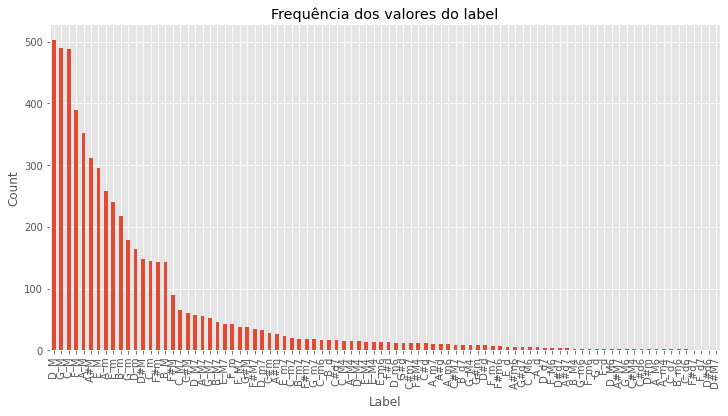

In [17]:
df.label.value_counts().plot(kind="bar")
plt.title("Frequência dos valores do label")
plt.xlabel("Label")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

## Encoding das Features e do Label

Serão criados dois apresentandos a mesma informação com transformações distintas:

1. As features e o label, que possuíam valores categóricos, serão convertidos atraves do [OrdinalEncoder] (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) da biblioteca Scikit-Learn. 

Esse dataset será utilizado em modelos baseados em árvore.

**É importante frisar que os labels são categóricos, e os valores convertidos não representam uma ordenação seguindo algum critério.**

- Para as features de frequência (YES|NO), os dados serão convertidos em valores binários 1 e 0
- Para a feature bass_pitch será atribuido um valor ordinal para cada uma dos 12 possíveis valores
- A feature meter mudará de escala de 1-5 para 0-4.
- Será feito um encoding do target para um valor ordinal para cada um dos 90 possíveis valores.

2. Nesse dataset a feature bass_pitch e o label serão transformados com OneHotEncoder para os outros tipos de modelo.

In [18]:
encoder = OrdinalEncoder()

In [19]:
ordinal_encoded_df = pd.DataFrame(encoder.fit_transform(df.drop(columns=['choral_id','event_number'])),columns=feature_cols+['label'])

In [20]:
ordinal_encoded_df.head()

,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,A#/Bb,B,bass_pitch,meter,label
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,2.0,69.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,4.0,31.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,1.0,31.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,2.0,69.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,1.0,69.0


In [21]:
one_hot_df = ordinal_encoded_df.drop(columns=['bass_pitch','label'])

In [22]:
enc = OneHotEncoder()

In [23]:
one_hot_bass_pitch = enc.fit_transform(np.array(df.bass_pitch).reshape(-1,1)).toarray()

In [24]:
one_hot_df = pd.concat([one_hot_df, pd.DataFrame(one_hot_bass_pitch,columns=enc.get_feature_names_out())],axis=1)

In [25]:
one_hot_df['label'] = list(enc.fit_transform(np.array(df.label).reshape(-1,1)).toarray())

In [26]:
enc.get_feature_names_out()

array(['x0_ A#M', 'x0_ A#M7', 'x0_ A#d', 'x0_ A#d7', 'x0_ A#m',
       'x0_ A#m6', 'x0_ A_M', 'x0_ A_M4', 'x0_ A_M6', 'x0_ A_M7',
       'x0_ A_d', 'x0_ A_m', 'x0_ A_m4', 'x0_ A_m6', 'x0_ A_m7',
       'x0_ B_M', 'x0_ B_M4', 'x0_ B_M7', 'x0_ B_d', 'x0_ B_d7',
       'x0_ B_m', 'x0_ B_m6', 'x0_ B_m7', 'x0_ C#M', 'x0_ C#M4',
       'x0_ C#M7', 'x0_ C#d', 'x0_ C#d6', 'x0_ C#d7', 'x0_ C#m',
       'x0_ C#m7', 'x0_ C_M', 'x0_ C_M4', 'x0_ C_M6', 'x0_ C_M7',
       'x0_ C_d6', 'x0_ C_d7', 'x0_ C_m', 'x0_ C_m6', 'x0_ C_m7',
       'x0_ D#M', 'x0_ D#M7', 'x0_ D#d', 'x0_ D#d6', 'x0_ D#d7',
       'x0_ D#m', 'x0_ D_M', 'x0_ D_M4', 'x0_ D_M6', 'x0_ D_M7',
       'x0_ D_d7', 'x0_ D_m', 'x0_ D_m6', 'x0_ D_m7', 'x0_ E_M',
       'x0_ E_M4', 'x0_ E_M7', 'x0_ E_d', 'x0_ E_m', 'x0_ E_m6',
       'x0_ E_m7', 'x0_ F#M', 'x0_ F#M4', 'x0_ F#M7', 'x0_ F#d',
       'x0_ F#d7', 'x0_ F#m', 'x0_ F#m6', 'x0_ F#m7', 'x0_ F_M',
       'x0_ F_M4', 'x0_ F_M6', 'x0_ F_M7', 'x0_ F_d', 'x0_ F_d7',
       'x0_ F_m', 'x0_

In [27]:
one_hot_df.head()

,C,C#/Db,D,D#/Eb,E,F,F#/Gb,G,G#/Ab,A,...,x0_C,x0_C#,x0_D,x0_D#,x0_E,x0_F,x0_F#,x0_G,x0_G#,label
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
one_hot_df.to_csv('one_hot_df.csv',index=False)
ordinal_encoded_df.to_csv('ordinal_encoded_df.csv',index=False)